In [12]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from evaluation.confidence_model import StatistcsConfidenceModel
from config import get_default_config
from netcal.presentation import ReliabilityRegression, ReliabilityQCE
from netcal.Helper import is_in_quantile
from netcal.regression import VarianceScaling, GPNormal, IsotonicRegression
from netcal.metrics import NLL, QCE

# unsupervised reliability diagram

In [14]:
method_names = ['ICA', 'CHROM', 'GREEN', 'LGI', 'OMIT', 'PBV', 'POS']
dataset_names = ["iBVP", "PURE", "UBFC-rPPG", "UBFC-Phys"]
test_dataset = "MAHNOB"
confidence_types = ['confidence_percentile']
confidence_model = StatistcsConfidenceModel(get_default_config())

losses_df = []
losses_df_test = []
quantiles = np.linspace(0.0, 1.0, 11)

# load df
for i, method_name in enumerate(method_names):
    # load
    dfs = []
    for dataset_name in dataset_names:
        df = pd.read_csv(f"results/unsupervised_inference/{dataset_name}_unsupervised_inference/{method_name}_metrics.csv")
        dfs.append(df)
    df = pd.concat(dfs, ignore_index=True)

    for confidence_type in confidence_types:
        # confidence -> std under gaussian prior
        confidence = df[confidence_type].values
        hr_std = [confidence_model.confidence_to_std(c) for c in confidence]
        df['hr_std'] = hr_std

        # original uncertainty
        print(f"training on {dataset_names} with {len(df)} samples")
        mean = np.array(df['hr_pred']).reshape(-1, 1)
        stddev = np.array(df['hr_std']).reshape(-1, 1)
        ground_truth = np.array(df['hr_label']).reshape(-1, 1)

        # define losses
        nll_loss = NLL()
        qce_loss = QCE()

        # plot
        fig = plt.figure(figsize=(5, 5))
        nll_original = nll_loss.measure((mean, stddev), ground_truth, kind='meanstd')
        qce_original = qce_loss.measure((mean, stddev), ground_truth, q=quantiles, kind='meanstd')
        diagram = ReliabilityRegression(quantiles=quantiles)
        diagram.plot((mean, stddev), ground_truth, title_suffix=f"{method_name}", fig=fig,
                        filename=f'results/svgs/reliability_diagram_{method_name}.svg',
                        dpi=300, bbox_inches='tight', format='svg')
        plt.close(fig)

        # variance scaling
        fig = plt.figure(figsize=(5, 5))
        varscaling = VarianceScaling()
        varscaling.fit((mean, stddev), ground_truth)
        stddev_varscaling = varscaling.transform((mean, stddev))
        diagram = ReliabilityRegression(quantiles=quantiles)
        diagram.plot((mean, stddev_varscaling), ground_truth, 
                        title_suffix=f"{method_name}-variance_scaled", fig=fig,
                        filename=f'results/svgs/reliability_diagram_{method_name}_variance_scaled.svg',
                        dpi=300, bbox_inches='tight', format='svg')
        nll_varscaled = nll_loss.measure((mean, stddev_varscaling), ground_truth, kind='meanstd')
        qce_varscaled = qce_loss.measure((mean, stddev_varscaling), ground_truth, q=quantiles, kind='meanstd')
        plt.close(fig)

        # Isotonic Regression
        fig = plt.figure(figsize=(5, 5))
        ir = IsotonicRegression()
        ir.fit((mean, stddev), ground_truth)
        t_isotonic, pdf_isotonic, cdf_isotonic = ir.transform(X=(mean, stddev), t=np.linspace(50, 150, 100))
        diagram = ReliabilityRegression(quantiles=quantiles)
        diagram.plot((t_isotonic, cdf_isotonic), ground_truth, 
                        title_suffix=f"{method_name}-isotonic",
                        kind='cumulative', fig=fig,
                        filename=f'results/svgs/reliability_diagram_{method_name}_isotonic.svg',
                        dpi=300, bbox_inches='tight', format='svg')
        nll_isotonic = nll_loss.measure((t_isotonic, cdf_isotonic), ground_truth, kind='cumulative')
        qce_isotonic = qce_loss.measure((t_isotonic, cdf_isotonic), ground_truth, q=quantiles, kind='cumulative')
        plt.close(fig)

        losses_df.append({
            'method_name': method_name,
            'nll': round(nll_original[0], 2),
            'qce': round(qce_original[0], 2),
            'nll_varscaled': round(nll_varscaled[0], 2),
            'qce_varscaled': round(qce_varscaled[0], 2),
            'nll_isotonic': round(nll_isotonic[0], 2),
            'qce_isotonic': round(qce_isotonic[0], 2)
        })

        # testing
        df_test = pd.read_csv(f"results/unsupervised_inference/{test_dataset}_unsupervised_inference/{method_name}_metrics.csv")
        confidence = df_test[confidence_type].values
        hr_std = [confidence_model.confidence_to_std(c) for c in confidence]
        df_test['hr_std'] = hr_std

        # original uncertainty
        mean = np.array(df_test['hr_pred']).reshape(-1, 1)
        stddev = np.array(df_test['hr_std']).reshape(-1, 1)
        ground_truth = np.array(df_test['hr_label']).reshape(-1, 1)
        fig = plt.figure(figsize=(5, 5))
        nll_original = nll_loss.measure((mean, stddev), ground_truth, kind='meanstd')
        qce_original = qce_loss.measure((mean, stddev), ground_truth, q=quantiles, kind='meanstd')
        diagram = ReliabilityRegression(quantiles=quantiles)
        diagram.plot((mean, stddev), ground_truth, title_suffix=f"{method_name}", fig=fig,
                        filename=f'results/svgs/testmahnob_reliability_diagram_{method_name}_original.svg',
                        dpi=300, bbox_inches='tight', format='svg')
        plt.close(fig)

        # variance scaling
        fig = plt.figure(figsize=(5, 5))
        stddev_varscaling = varscaling.transform((mean, stddev))
        diagram = ReliabilityRegression(quantiles=quantiles)
        diagram.plot((mean, stddev_varscaling), ground_truth, 
                        title_suffix=f"{method_name}-variance_scaled", fig=fig,
                        filename=f'results/svgs/testmahnob_reliability_diagram_{method_name}_variance_scaled.svg',
                        dpi=300, bbox_inches='tight', format='svg')
        nll_varscaled = nll_loss.measure((mean, stddev_varscaling), ground_truth, kind='meanstd')
        qce_varscaled = qce_loss.measure((mean, stddev_varscaling), ground_truth, q=quantiles, kind='meanstd')
        plt.close(fig)

        # Isotonic Regression
        fig = plt.figure(figsize=(5, 5))
        t_isotonic, pdf_isotonic, cdf_isotonic = ir.transform(X=(mean, stddev), t=np.linspace(50, 150, 100))
        diagram = ReliabilityRegression(quantiles=quantiles)
        diagram.plot((t_isotonic, cdf_isotonic), ground_truth, 
                        title_suffix=f"{method_name}-isotonic",
                        kind='cumulative', fig=fig,
                        filename=f'results/svgs/testmahnob_reliability_diagram_{method_name}_isotonic.svg',
                        dpi=300, bbox_inches='tight', format='svg')
        nll_isotonic = nll_loss.measure((t_isotonic, cdf_isotonic), ground_truth, kind='cumulative')
        qce_isotonic = qce_loss.measure((t_isotonic, cdf_isotonic), ground_truth, q=quantiles, kind='cumulative')
        plt.close(fig)

        losses_df_test.append({
            'method_name': method_name,
            'nll': round(nll_original[0], 2),
            'qce': round(qce_original[0], 2),
            'nll_varscaled': round(nll_varscaled[0], 2),
            'qce_varscaled': round(qce_varscaled[0], 2),
            'nll_isotonic': round(nll_isotonic[0], 2),
            'qce_isotonic': round(qce_isotonic[0], 2)
        })

losses_df = pd.DataFrame(losses_df)
losses_df.to_csv('losses_df_unsupervised.csv', index=False)

losses_df_test = pd.DataFrame(losses_df_test)
losses_df_test.to_csv('losses_df_unsupervised_test.csv', index=False)

training on ['iBVP', 'PURE', 'UBFC-rPPG', 'UBFC-Phys'] with 47945 samples
training on ['iBVP', 'PURE', 'UBFC-rPPG', 'UBFC-Phys'] with 47945 samples
training on ['iBVP', 'PURE', 'UBFC-rPPG', 'UBFC-Phys'] with 47945 samples
training on ['iBVP', 'PURE', 'UBFC-rPPG', 'UBFC-Phys'] with 47945 samples
training on ['iBVP', 'PURE', 'UBFC-rPPG', 'UBFC-Phys'] with 47945 samples
training on ['iBVP', 'PURE', 'UBFC-rPPG', 'UBFC-Phys'] with 47945 samples
training on ['iBVP', 'PURE', 'UBFC-rPPG', 'UBFC-Phys'] with 47945 samples


# supervised raliability diagram


In [15]:
method_names = ['deepphys', 'efficientphys', 'factorizephys', 'ibvpnet', 'physformer', 'physnet', 'rhythmformer', 'tscan']
dataset_names = ["PURE", "UBFC-rPPG", "UBFC-Phys", "iBVP"]
trained_dataset = "pure"
mode = "supervised"
confidence_types = ['confidence_percentile']
confidence_model = StatistcsConfidenceModel(get_default_config())

losses_df = []

# load df
for i, method_name in enumerate(method_names):
    # load
    dfs = []
    for dataset_name in dataset_names:
        csv_path = f"results/{mode}_inference/{dataset_name}_{method_name}_inference/{method_name}-{trained_dataset}_metrics.csv"
        if os.path.exists(csv_path):
            df = pd.read_csv(csv_path)
            dfs.append(df)
    df = pd.concat(dfs, ignore_index=True)

    for confidence_type in confidence_types:
        # confidence -> std under gaussian prior
        confidence = df[confidence_type].values
        hr_std = [confidence_model.confidence_to_std(c) for c in confidence]
        df['hr_std'] = hr_std

        # original uncertainty
        print(f"training on {dataset_names} with {len(df)} samples")
        mean = np.array(df['hr_pred']).reshape(-1, 1)
        stddev = np.array(df['hr_std']).reshape(-1, 1)
        ground_truth = np.array(df['hr_label']).reshape(-1, 1)

        # define losses
        nll_loss = NLL()
        qce_loss = QCE()

        # plot
        fig = plt.figure(figsize=(5, 5))
        quantiles = np.linspace(0.0, 1.0, 11)
        nll_original = nll_loss.measure((mean, stddev), ground_truth, kind='meanstd')
        qce_original = qce_loss.measure((mean, stddev), ground_truth, q=quantiles, kind='meanstd')
        diagram = ReliabilityRegression(quantiles=quantiles)
        diagram.plot((mean, stddev), ground_truth, title_suffix=f"{method_name}", fig=fig,
                        filename=f'results/svgs/reliability_diagram_{method_name}.svg',
                        dpi=300, bbox_inches='tight', format='svg')
        plt.close(fig)

        # variance scaling
        fig = plt.figure(figsize=(5, 5))
        varscaling = VarianceScaling()
        varscaling.fit((mean, stddev), ground_truth)
        stddev_varscaling = varscaling.transform((mean, stddev))
        diagram = ReliabilityRegression(quantiles=quantiles)
        diagram.plot((mean, stddev_varscaling), ground_truth, 
                        title_suffix=f"{method_name}-variance_scaled", fig=fig,
                        filename=f'results/svgs/reliability_diagram_{method_name}_variance_scaled.svg',
                        dpi=300, bbox_inches='tight', format='svg')
        nll_varscaled = nll_loss.measure((mean, stddev_varscaling), ground_truth, kind='meanstd')
        qce_varscaled = qce_loss.measure((mean, stddev_varscaling), ground_truth, q=quantiles, kind='meanstd')
        plt.close(fig)

        # Isotonic Regression
        fig = plt.figure(figsize=(5, 5))
        ir = IsotonicRegression()
        ir.fit((mean, stddev), ground_truth)
        t_isotonic, pdf_isotonic, cdf_isotonic = ir.transform(X=(mean, stddev), t=np.linspace(50, 150, 100))
        diagram = ReliabilityRegression(quantiles=quantiles)
        diagram.plot((t_isotonic, cdf_isotonic), ground_truth, 
                        title_suffix=f"{method_name}-isotonic",
                        kind='cumulative', fig=fig,
                        filename=f'results/svgs/reliability_diagram_{method_name}_isotonic.svg',
                        dpi=300, bbox_inches='tight', format='svg')
        nll_isotonic = nll_loss.measure((t_isotonic, cdf_isotonic), ground_truth, kind='cumulative')
        qce_isotonic = qce_loss.measure((t_isotonic, cdf_isotonic), ground_truth, q=quantiles, kind='cumulative')
        plt.close(fig)

        losses_df.append({
            'method_name': f"{method_name}-{trained_dataset}",
            'nll': round(nll_original[0], 2),
            'qce': round(qce_original[0], 2),
            'nll_varscaled': round(nll_varscaled[0], 2),
            'qce_varscaled': round(qce_varscaled[0], 2),
            'nll_isotonic': round(nll_isotonic[0], 2),
            'qce_isotonic': round(qce_isotonic[0], 2)
        })

losses_df = pd.DataFrame(losses_df)
losses_df.to_csv('losses_df_supervised.csv', index=False)

training on ['PURE', 'UBFC-rPPG', 'UBFC-Phys', 'iBVP'] with 34094 samples
training on ['PURE', 'UBFC-rPPG', 'UBFC-Phys', 'iBVP'] with 34094 samples
training on ['PURE', 'UBFC-rPPG', 'UBFC-Phys', 'iBVP'] with 34329 samples
training on ['PURE', 'UBFC-rPPG', 'UBFC-Phys', 'iBVP'] with 34329 samples
training on ['PURE', 'UBFC-rPPG', 'UBFC-Phys', 'iBVP'] with 34329 samples
training on ['PURE', 'UBFC-rPPG', 'UBFC-Phys', 'iBVP'] with 34622 samples
training on ['PURE', 'UBFC-rPPG', 'UBFC-Phys', 'iBVP'] with 34329 samples
training on ['PURE', 'UBFC-rPPG', 'UBFC-Phys', 'iBVP'] with 34094 samples


# calibrated distribution visualization

(100, 3552, 1)


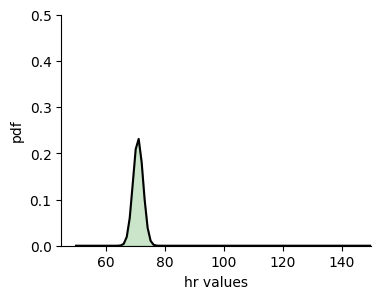

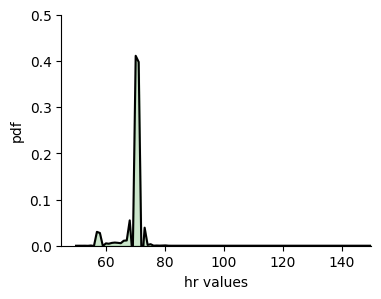

In [3]:
from matplotlib import pyplot as plt
from scipy import stats

print(t_isotonic.shape)

idx = 50
mean_sample = mean[idx]
stddev_sample = stddev[idx]
t = t_isotonic[:, idx, :]
gaussian_pdf = stats.norm.pdf(t, mean_sample, stddev_sample)
gaussian_cdf = stats.norm.cdf(t, mean_sample, stddev_sample)
calibrated_pdf = pdf_isotonic[:, idx, :]
calibrated_cdf = cdf_isotonic[:, idx, :]

plt.figure(figsize=(4, 3))
plt.xlim(45, 150)
plt.ylim(0, 0.5)
# plt.title(f"mean={mean_sample}, std={stddev_sample}")
plt.plot(t, gaussian_pdf, color='black')
plt.fill_between(t.flatten(), np.zeros_like(t.flatten()), gaussian_pdf.flatten(), color='green', alpha=0.2)
plt.xlabel("hr values")
plt.ylabel("pdf")
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gcf().patch.set_alpha(0.5)
plt.gca().patch.set_alpha(0.5)
plt.savefig('original_hr_pdf.svg', dpi=300, bbox_inches='tight', format='svg')
plt.show()

plt.figure(figsize=(4, 3))
plt.xlim(45, 150)
plt.ylim(0, 0.5)
# plt.title(f"mean={mean_sample}, std={stddev_sample}")
plt.plot(t, calibrated_pdf, label="calibrated hr pdf", color='black')
plt.fill_between(t.flatten(), np.zeros_like(t.flatten()), calibrated_pdf.flatten(), color='green', alpha=0.2)
plt.xlabel("hr values")
plt.ylabel("pdf")
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gcf().patch.set_alpha(0.5)
plt.gca().patch.set_alpha(0.5)
plt.savefig('calibrated_hr_pdf.svg', dpi=300, bbox_inches='tight', format='svg')
plt.show()


# fig, (ax1, ax2) = plt.subplots(2, 1)

# # plot the recalibrated PDF within a single axis after calibration
# t = t_isotonic[:, 0, 0]
# pdf_calibrated = pdf_isotonic[:, 0, 0]
# cdf_calibrated = cdf_isotonic[:, 0, 0]
# mean = mean[0]
# stddev = stddev[0]
# gaussian_pdf = stats.norm.pdf(t, mean, stddev)
# ax1.plot(
#     t, gaussian_pdf, # before calibration
#     t, pdf_calibrated, # after calibration
# )
# ax1.set_title("pdf")

# # plot the recalibrated PDF within a single axis after calibration
# gaussian_cdf = stats.norm.cdf(t, mean, stddev)
# ax2.plot(
#     t, gaussian_cdf, # before calibration
#     t, cdf_calibrated, # after calibration
# )
# ax2.set_title("cdf")

# plt.show()

testing on ['UBFC-rPPG'] with 2286 samples


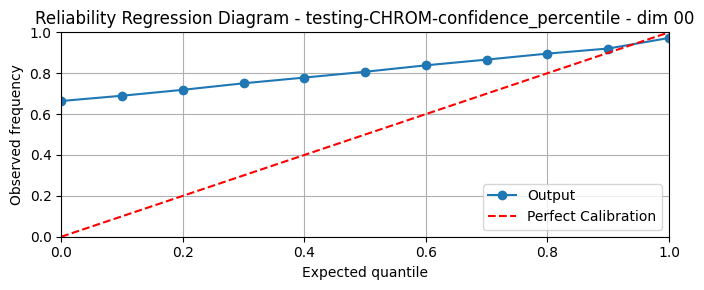

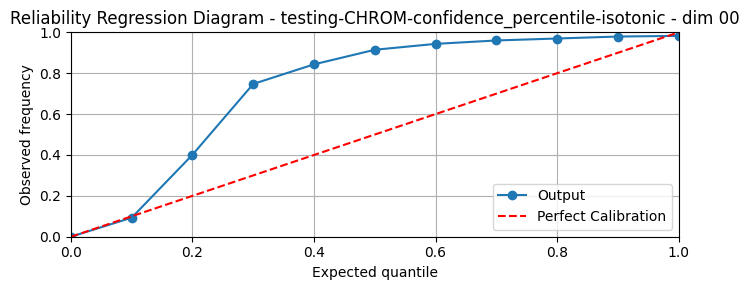

In [17]:
method_names = ['CHROM']
dataset_names = ["UBFC-rPPG"]
confidence_types = ['confidence_percentile']

config_file = "configs/confidence_model.yaml"
config = get_config(config_file=config_file)
confidence_model = StatistcsConfidenceModel(config)

# load df
for i, method_name in enumerate(method_names):
    # load
    dfs = []
    for dataset_name in dataset_names:
        df = pd.read_csv(f"results/{dataset_name}_unsupervised_inference/{method_name}_metrics.csv")
        dfs.append(df)
    df = pd.concat(dfs, ignore_index=True)

    for confidence_type in confidence_types:
        # confidence -> std under gaussian prior
        confidence = df[confidence_type].values
        hr_std = [confidence_model.confidence_to_std(c) for c in confidence]
        df['hr_std'] = hr_std

        # original uncertainty
        print(f"testing on {dataset_names} with {len(df)} samples")
        mean = np.array(df['hr_pred']).reshape(-1, 1)
        stddev = np.array(df['hr_std']).reshape(-1, 1)
        ground_truth = np.array(df['hr_label']).reshape(-1, 1)

        # plot
        quantiles = np.linspace(0.0, 1.0, 11)
        diagram = ReliabilityRegression(quantiles=quantiles)
        diagram.plot((mean, stddev), ground_truth, title_suffix=f"testing-{method_name}-{confidence_type}")

        # Isotonic Regression
        t_isotonic, pdf_isotonic, cdf_isotonic = ir.transform(X=(mean, stddev), t=np.linspace(50, 150, 100))
        diagram = ReliabilityRegression(quantiles=quantiles)
        diagram.plot((t_isotonic, cdf_isotonic), ground_truth, 
                        title_suffix=f"testing-{method_name}-{confidence_type}-isotonic",
                        kind='cumulative')